# Trabajo Práctio IA 2024

## Detector de estrés.

El conjunto de datos que utilizamos para este proyecto contiene datos publicados en subreddits relacionados con la salud mental. Este conjunto de datos contiene varios problemas de salud mental que las personas compartieron sobre su vida. Afortunadamente, este conjunto de datos está etiquetado como 0 y 1, donde 0 indica que no hay estrés y 1 indica estrés.

A continuacion realizaremos el analisis de los datos junto a su modelo de deteccion de estrés.




In [48]:
#Importamos las librerias que vamos a necesitar.
import pandas as pd
import numpy as np
import io
import nltk
import re
import string
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
import warnings
warnings.filterwarnings('ignore')

In [49]:
#Seleccionamos el dataset.
from google.colab import files
uploaded = files.upload()

Saving stress.csv to stress.csv


In [50]:
#Vemos las primeras 5 filas.
datost = pd.read_csv(io.BytesIO(uploaded['stress.csv']))
datost.head()

,subreddit,post_id,sentence_range,text,id,label,confidence,social_timestamp,social_karma,syntax_ari,...,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",33181,1,0.8,1521614353,5,1.806818,...,1.000,1.1250,1.0,1.77000,1.52211,1.89556,0.86,1,3.253573,-0.002742
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",2606,0,1.0,1527009817,4,9.429737,...,1.125,1.0000,1.0,1.69586,1.62045,1.88919,0.65,2,8.828316,0.292857
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,38816,1,0.8,1535935605,2,7.769821,...,1.000,1.1429,1.0,1.83088,1.58108,1.85828,0.67,0,7.841667,0.011894
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",239,1,0.6,1516429555,0,2.667798,...,1.000,1.1250,1.0,1.75356,1.52114,1.98848,0.50,5,4.104027,0.141671
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1421,1,0.8,1539809005,24,7.554238,...,1.000,1.1250,1.0,1.77644,1.64872,1.81456,1.00,1,7.910952,-0.204167


In [51]:
#Observamos la cantidad de observaciones y caracteristicas del dataset (filas y columnas).
datost.shape

(2838, 116)

In [52]:
#Vemos los nombres de todas las columnas del dataset.
datost.columns.values

array(['subreddit', 'post_id', 'sentence_range', 'text', 'id', 'label',
       'confidence', 'social_timestamp', 'social_karma', 'syntax_ari',
       'lex_liwc_WC', 'lex_liwc_Analytic', 'lex_liwc_Clout',
       'lex_liwc_Authentic', 'lex_liwc_Tone', 'lex_liwc_WPS',
       'lex_liwc_Sixltr', 'lex_liwc_Dic', 'lex_liwc_function',
       'lex_liwc_pronoun', 'lex_liwc_ppron', 'lex_liwc_i', 'lex_liwc_we',
       'lex_liwc_you', 'lex_liwc_shehe', 'lex_liwc_they',
       'lex_liwc_ipron', 'lex_liwc_article', 'lex_liwc_prep',
       'lex_liwc_auxverb', 'lex_liwc_adverb', 'lex_liwc_conj',
       'lex_liwc_negate', 'lex_liwc_verb', 'lex_liwc_adj',
       'lex_liwc_compare', 'lex_liwc_interrog', 'lex_liwc_number',
       'lex_liwc_quant', 'lex_liwc_affect', 'lex_liwc_posemo',
       'lex_liwc_negemo', 'lex_liwc_anx', 'lex_liwc_anger',
       'lex_liwc_sad', 'lex_liwc_social', 'lex_liwc_family',
       'lex_liwc_friend', 'lex_liwc_female', 'lex_liwc_male',
       'lex_liwc_cogproc', 'lex_liwc_insig

In [53]:
#Agregamos la columna 'text_spanish' para utilizarla mas adelante.
datost.loc[:, 'text_spanish'] = ''
datost.head()

,subreddit,post_id,sentence_range,text,id,label,confidence,social_timestamp,social_karma,syntax_ari,...,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment,text_spanish
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",33181,1,0.8,1521614353,5,1.806818,...,1.1250,1.0,1.77000,1.52211,1.89556,0.86,1,3.253573,-0.002742,
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",2606,0,1.0,1527009817,4,9.429737,...,1.0000,1.0,1.69586,1.62045,1.88919,0.65,2,8.828316,0.292857,
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,38816,1,0.8,1535935605,2,7.769821,...,1.1429,1.0,1.83088,1.58108,1.85828,0.67,0,7.841667,0.011894,
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",239,1,0.6,1516429555,0,2.667798,...,1.1250,1.0,1.75356,1.52114,1.98848,0.50,5,4.104027,0.141671,
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1421,1,0.8,1539809005,24,7.554238,...,1.1250,1.0,1.77644,1.64872,1.81456,1.00,1,7.910952,-0.204167,


In [54]:
#Seleccionamos las columnas con las que vamos a trabajar para hacer menos pesado el dataset y lo mostramos.
df = datost[['subreddit', 'post_id', 'sentence_range', 'text','id', 'label', 'text_spanish']]
df.head()

,subreddit,post_id,sentence_range,text,id,label,text_spanish
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",33181,1,
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",2606,0,
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,38816,1,
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",239,1,
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1421,1,


In [55]:
#Observamos la cantidad de observaciones y caracteristicas del nuevo dataset (filas y columnas).
df.shape

(2838, 7)

In [ ]:
'''
Queda solo a modo de comentario ya que lo utilizamos cuando no podiamos traducir todo el texto.

#Elimino 1000 filas de dataframe debido a que sino no es posible traducirlo para poder utilizarlo en espa;ol
# Seleccionar 1000 filas aleatorias para eliminar
rows_to_remove = np.random.choice(df.index, size=1000, replace=False)

# Eliminar las filas seleccionadas
df = df.drop(rows_to_remove).reset_index(drop=True)
df.shape
df.head(10)
'''

In [46]:
#Instalamos deep-translator para luego poder realizar la traduccion de los textos.
!pip install deep-translator

In [56]:
#Traducimos la columna "text" ya que se quiere crear un modelo que analice textos en español.

#Esta es la clase utilizada para traducir textos de un idioma a otro.
#En este caso, se usa para traducir de inglés ('en') a español ('es').
from deep_translator import GoogleTranslator

#Estas herramientas nos permiten ejecutar tareas en paralelo, es decir,
#se pueden procesar varios lotes de textos simultáneamente para acelerar el proceso de traducción.
from concurrent.futures import ThreadPoolExecutor, as_completed

#Creamos una instancia del traductor.
translator = GoogleTranslator(source='en', target='es')

#Define el tamaño de cada lote de textos que se traducirán en una sola operación.
#En este caso, 720 textos se procesarán juntos en cada lote.
batch_size = 720

#Dividimos la columna 'text' en lotes y traducimos en paralelo.
#Contiene los textos que se van a traducir.
texts = df['text']

#Creamos una lista del mismo tamaño que texts pero llena de None.
#Esta lista almacenará los textos traducidos.
translated_texts = [None] * len(texts)

#Función principal
def translate_in_parallel(texts, batch_size):
    futures = []
    indices = []
    #Crea un grupo de 30 hilos de trabajo (threads), que pueden ejecutar tareas en paralelo.
    with ThreadPoolExecutor(max_workers=30) as executor:
        #Recorre los textos en lotes, cada uno con el tamaño definido por batch_size.
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i + batch_size]
            #'executor.submit' envía la tarea de traducir el lote al grupo de hilos.
            #Cada tarea es el resultado de una función lambda que traduce cada texto en el lote.
            #La variable 'future' es una lista de objetos futuros, que representan las tareas en progreso.
            future = executor.submit(lambda b: [translator.translate(text) for text in b], batch)
            futures.append(future)
            #Una lista que guarda el índice de inicio de cada lote para saber dónde
            #colocar los textos traducidos en la lista final.
            indices.append(i)
    #Recorre las tareas en paralelo, recuperando el resultado de cada una y su índice correspondiente.
    for future, index in zip(futures, indices):
        result = future.result()
        #Coloca los textos traducidos en la posición correcta dentro de translated_texts.
        translated_texts[index:index + len(result)] = result

translate_in_parallel(texts, batch_size)

#Creamos una nueva columna en el DataFrame para almacenar los textos traducidos al español.
df['text_spanish'] = translated_texts


In [57]:
#Guardamos una copia de dataframe por si luego tarda mucho la traduccion.
df.to_csv('stress_spanish.csv', index=False)

In [59]:
#Vemos los textos traducidos.
df.head(10)

,subreddit,post_id,sentence_range,text,id,label,text_spanish
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",33181,1,"Dijo que nunca se había sentido así antes, me ..."
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",2606,0,"Hola r/assistance, no estoy seguro de si este ..."
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,38816,1,Entonces mi mamá me golpeó con el periódico y ...
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",239,1,"hasta que conocí a mi nuevo novio, él es incre..."
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1421,1,Octubre es el Mes de Concientización sobre la ...
5,relationships,7tx7et,"(30, 35)",I think he doesn't want to put in the effort f...,17554,1,Creo que él no quiere esforzarse para que la r...
6,domesticviolence,7iphly,"[25, 30]",It was a big company so luckily I didn't have ...,165,0,"Era una empresa grande, así que por suerte no ..."
7,anxiety,5m3k80,"(5, 10)",It cleared up and I was okay but. On Monday ...,33053,1,"Se aclaró y estuve bien, pero el lunes estaba ..."
8,relationships,7nhy1v,"(50, 55)",I actually give an assistant half my emergency...,7581,1,"De hecho, a veces le doy a un asistente la mit..."
9,assistance,61eiq6,"[15, 20]",I just feel like the street life has fucked my...,1517,1,Siento que la vida en la calle me ha jodido la...


In [60]:
#Nos fijamos si hay nulos en el dataset.
print(df.isnull().sum())

subreddit         0
post_id           0
sentence_range    0
text              0
id                0
label             0
text_spanish      0
dtype: int64


In [61]:
#Limpiamos la columna de texto de palabras vacias, enlaces, simbolos especiales y errores del idioma.
from nltk.corpus import stopwords

#Descargamos las stopwords de NLTK.
nltk.download('stopwords')

#Definimos las stopwords
stopword = set(stopwords.words('spanish'))

#Definimos la función de limpieza.
def clean(text):
    text = str(text).lower()
    text = re.sub(r'\[.*?\]', '', text)  #Eliminamos texto entre corchetes.
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  #Eliminamos URLs.
    text = re.sub(r'<.*?>+', '', text)  #Eliminamos etiquetas HTML.
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)  #Eliminamos puntuación.
    text = re.sub(r'\n', '', text)  #Eliminamos saltos de línea.
    text = re.sub(r'\w*\d\w*', '', text)  #Eliminamos palabras que contienen números.
    text = [word for word in text.split(' ') if word not in stopword]  # Eliminar stopwords.
    text = " ".join(text)
    return text

#Aplicamos la función de limpieza a la columna 'text'.
df["text_spanish"] = df["text_spanish"].apply(clean)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


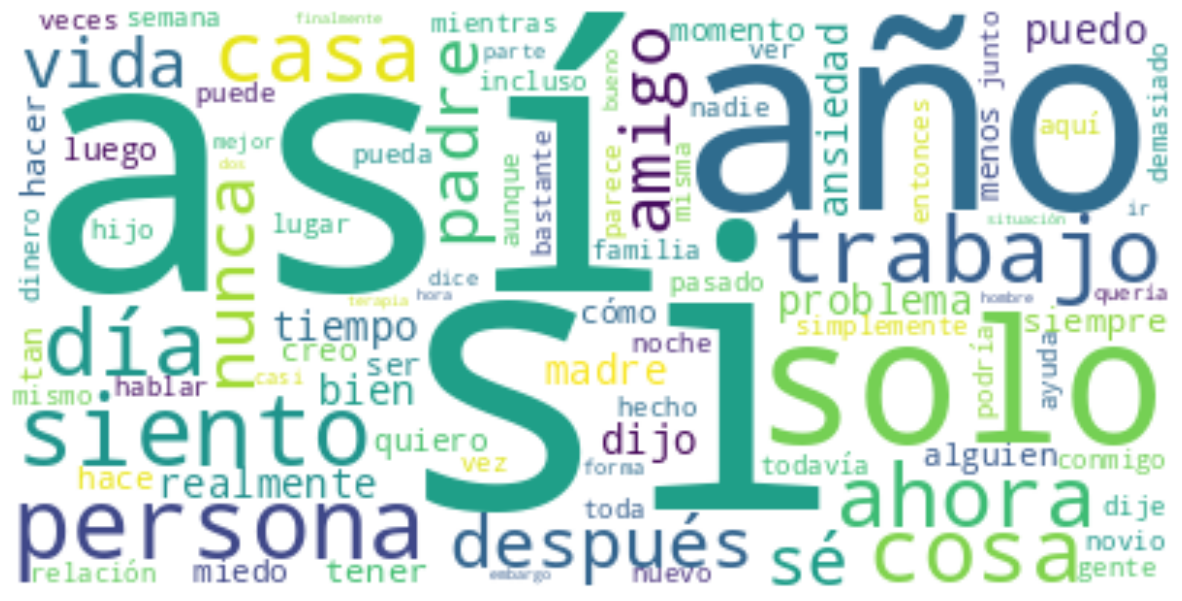

In [62]:
#Analizamos las palabras mas utilizadas por
#las personas que comparten los problemas diarios de sus vidas en las redes sociales.
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
text = " ".join(i for i in df.text_spanish)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords,
                      background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

<Axes: title={'center': 'Cantidad de registros con y sin estrés'}, xlabel='Estrés', ylabel='Cantidad'>

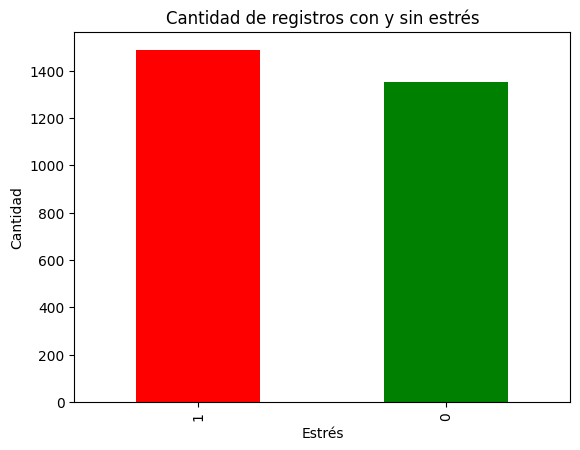

In [64]:
#Conteo de stress.
label_count = df.label.value_counts()

#Definimos los colores para cada label.
#0 significa que no hay estrés y 1 significa que hay estrés.
color_dict = {1:'red', 0:'green'}
colors = [color_dict[label] for label in label_count.index]

#Generamos el grafico de conteo de cantidad de registros con y sin estrés.
label_count.plot(kind='bar', title = 'Cantidad de registros con y sin estrés', color=colors, xlabel='Estrés', ylabel='Cantidad')

In [65]:
#MODELO DE DETECCION DE ESTRES

#La columna de "label" de este conjunto de datos contiene las etiquetas 0 y 1.
#0 significa que no hay estrés y 1 significa que hay estrés.
#Utilizaremos las etiquetas "Hay estrés y "No hay estrés" en lugar de 1 y 0.
#Prepararemos esta columna en consecuencia y seleccionaremos las columnas de texto y etiqueta
#para el proceso de entrenamiento de un modelo de aprendizaje automático.
df["label"] = df["label"].map({0: "No hay estrés", 1: "Hay estrés"})
data = df[["text_spanish", "label"]]

#Observamos los cambios.
data.head()

,text_spanish,label
0,dijo nunca así sugirió descansara así ¡prueba ...,Hay estrés
1,hola rassistance seguro si lugar correcto publ...,No hay estrés
2,entonces mamá golpeó periódico sorprendió hici...,Hay estrés
3,conocí nuevo novio increíble amable dulce buen...,Hay estrés
4,octubre mes concientización violencia doméstic...,Hay estrés


In [66]:
#Dividimos el dataset en training y test sets.
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

x = np.array(df["text_spanish"])
y = np.array(df["label"])

cv = CountVectorizer()
X = cv.fit_transform(x)
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=67)

In [68]:
#Entrenamos el modelo de detección de estrés.
from sklearn.naive_bayes import BernoulliNB
model = BernoulliNB()
model.fit(xtrain, ytrain)

BernoulliNB()

In [69]:
#score del modelo
print(model.score(xtest, ytest))

0.7253521126760564


In [74]:
#Ahora probamos el rendimiento de nuestro modelo en algunas oraciones
#aleatorias basadas en la salud mental.

#Pruebas para "Hay estres" : A veces siento que necesito ayuda, Tengo muchas cosas para hacer, me trataron mal hoy en el trabajo, me despidieron.
#Prueba para "No hay estres" : La gente necesita cuidar su salud mental,

user = input("Enter a Text: ")
data = cv.transform([user]).toarray()
output = model.predict(data)
print(output)

Enter a Text: me despidieron
['Hay estrés']
